# Margin decreases linearly every epoch until 0.1

# Install and import

In [1]:
%matplotlib inline
from tqdm import trange
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
from pytorch_metric_learning.utils import common_functions
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from pytorch_metric_learning.utils.inference import MatchFinder, InferenceModel
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
import torchvision
from torchvision import datasets, transforms
import torch
import torch.nn as nn

from PIL import Image
import logging
import matplotlib.pyplot as plt
import umap
from cycler import cycler
import record_keeper
import pytorch_metric_learning
import os
from torchvision.datasets.folder import default_loader
import datetime


logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s"%pytorch_metric_learning.__version__)
    

INFO:root:VERSION 0.9.90.dev0


In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
from torch.utils.tensorboard import SummaryWriter

In [2]:
%load_ext tensorboard

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Dataset

## Transforms

In [4]:
# Set the image transforms
train_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(size=227),
                                    transforms.RandomHorizontalFlip(0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(size=227),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


## CUB-2011 dataset and class-disjoint train/val splits

In [5]:
# !wget https://raw.githubusercontent.com/TDeVries/cub2011_dataset/master/cub2011.py

In [6]:
from cub2011 import Cub2011

In [7]:
original_train = Cub2011(root="CUB2011", train=True, transform=None, download=False)
original_val = Cub2011(root="CUB2011", train=False, transform=None, download=False)

In [8]:
n_classes = max(max(original_train.data.target), max(original_val.data.target))
n_classes

200

In [9]:
class ClassDisjointDataSet(torch.utils.data.Dataset):
    def __init__(self, original_train, original_val, train, split_point=0.5, n_classes=100, transform=None):
        self.original_train = original_train
        self.original_val = original_val

        split_class = round(split_point*n_classes)
        rule = (lambda x: x < split_class) if train else (lambda x: x >=split_class)
        train_filtered_idx = [i for i,x in enumerate(original_train.data.target) if rule(x)]
        val_filtered_idx = [i for i,x in enumerate(original_val.data.target) if rule(x)]
        
        train_fpaths = original_train.data.iloc[train_filtered_idx].apply(
            lambda x: os.path.join(self.original_train.root, self.original_train.base_folder, x.filepath),
            axis=1
        )
        val_fpaths = original_val.data.iloc[val_filtered_idx].apply(
            lambda x: os.path.join(self.original_val.root, self.original_val.base_folder, x.filepath),
            axis=1
        )

        self.img_paths = np.concatenate([train_fpaths, val_fpaths])
        self.data = np.concatenate([original_train.data.iloc[train_filtered_idx], original_val.data.iloc[val_filtered_idx]], axis=0)
        self.targets = np.concatenate([np.array(original_train.data.target)[train_filtered_idx], np.array(original_val.data.target)[val_filtered_idx]], axis=0)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):            
        path, target = self.img_paths[index], self.targets[index]
        img = default_loader(path)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

train_dataset = ClassDisjointDataSet(original_train, original_val, True, n_classes=n_classes, transform=train_transform)
val_dataset = ClassDisjointDataSet(original_train, original_val, False, n_classes=n_classes, transform=val_transform)
assert set(train_dataset.targets).isdisjoint(set(val_dataset.targets))

# Prepare for training

## Model

In [10]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

In [11]:
# Set trunk model and replace the softmax layer with an identity function
trunk = torchvision.models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = common_functions.Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 512, 512]).to(device))

## Optimizers

In [12]:
# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.00001, weight_decay=0.0001)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.001, weight_decay=0.0001)

## Create the loss, miner, sampler, and package them into dictionaries


In [13]:
loss = losses.TripletMarginLoss(margin=0.5)

miner = miners.MultiSimilarityMiner(epsilon=0.1)

sampler = samplers.MPerClassSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset))


# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

## Create the trainer

In [14]:
batch_size = 32
num_epochs = 40

In [15]:
experiment_id = datetime.datetime.now().strftime("%m-%d %H:%M")
experiment_dir = os.path.join('experiment_logs', experiment_id)

In [16]:
record_keeper, _, _ = logging_presets.get_record_keeper(experiment_dir, os.path.join('experiment_logs', 'tensorboard', experiment_id))
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"val": val_dataset}
model_folder = experiment_id

def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname, *args):
    logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
    label_set = np.unique(labels)
    num_classes = len(label_set)
    fig = plt.figure(figsize=(20,15))
    plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
    for i in range(num_classes):
        idx = labels == label_set[i]
        plt.plot(umap_embeddings[idx, 0], umap_embeddings[idx, 1], ".", markersize=1)   
    plt.show()
    
    writer = SummaryWriter()
    writer.add_embedding(umap_embeddings, labels)
    writer.close()

# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook = hooks.end_of_testing_hook, 
                                            visualizer = umap.UMAP(), 
                                            visualizer_hook = visualizer_hook,
                                            dataloader_num_workers = 32)

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            test_interval = 5,
                                            patience = 2)

In [17]:
start_margin = 0.5
min_margin = 0.1

over_epochs = 15

per_step = (start_margin - min_margin)/over_epochs

cur_epoch = 0
def end_of_epoch_wrapper_hook(*args, **kwargs):
    if loss.margin >= min_margin:
        loss.margin -= per_step
        print('Margin is now', loss.margin)
    return end_of_epoch_hook(*args, **kwargs)
per_step

0.02666666666666667

In [18]:
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers = 32,
                                end_of_iteration_hook = hooks.end_of_iteration_hook,
                                end_of_epoch_hook = end_of_epoch_wrapper_hook)

# Train the model

In [19]:
%tensorboard --logdir experiment_logs/tensorboard

Reusing TensorBoard on port 6006 (pid 9200), started 0:55:58 ago. (Use '!kill 9200' to kill it.)

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
total_loss=0.46465: 100%|██████████| 173/173 [00:24<00:00,  7.07it/s]
INFO:root:TRAINING EPOCH 2
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.47333333333333333


total_loss=0.47911: 100%|██████████| 173/173 [00:25<00:00,  6.92it/s]
INFO:root:TRAINING EPOCH 3
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.44666666666666666


total_loss=0.41511: 100%|██████████| 173/173 [00:25<00:00,  6.77it/s]
INFO:root:TRAINING EPOCH 4
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.42


total_loss=0.37998: 100%|██████████| 173/173 [00:25<00:00,  6.86it/s]
INFO:root:TRAINING EPOCH 5
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.3933333333333333


total_loss=0.37102: 100%|██████████| 173/173 [00:24<00:00,  7.10it/s]
INFO:root:Evaluating epoch 5
INFO:root:Getting embeddings for the val split
  0%|          | 0/187 [00:00<?, ?it/s]

Margin is now 0.36666666666666664


100%|██████████| 187/187 [00:10<00:00, 17.12it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


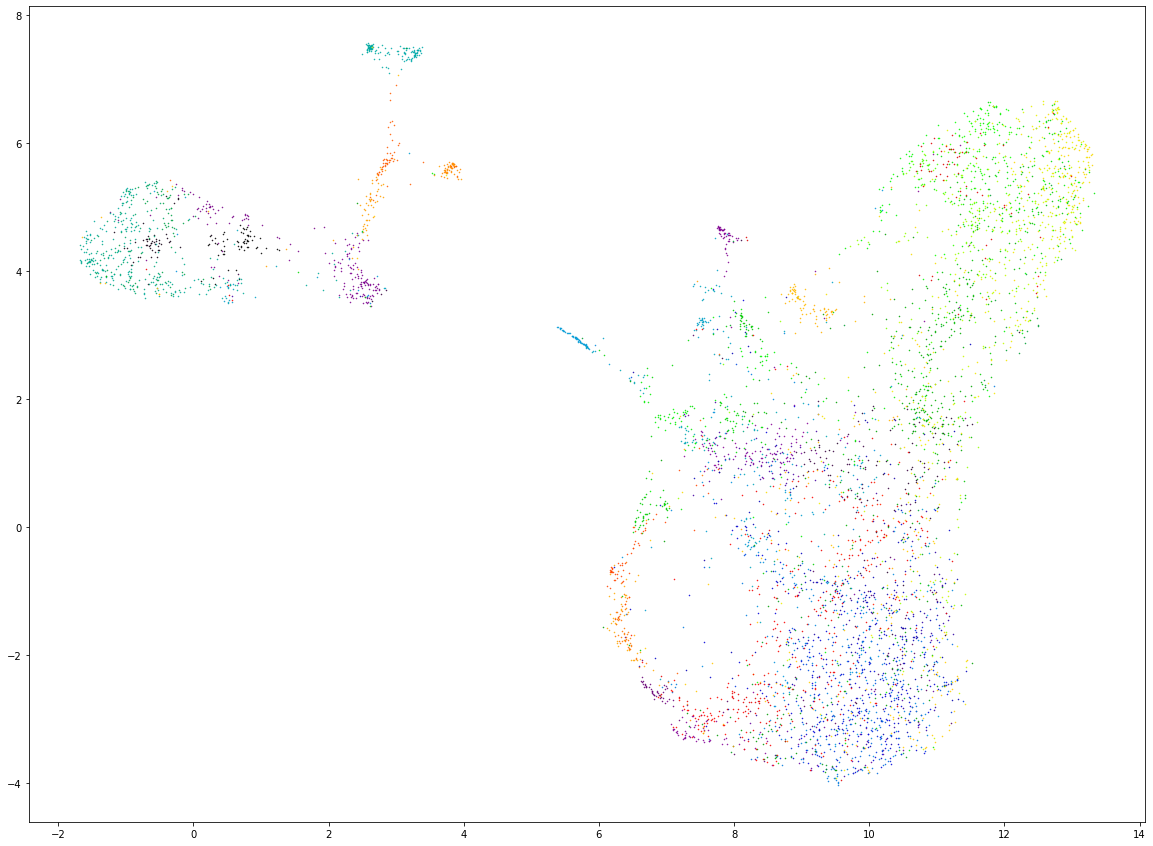

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 512
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 512
INFO:root:New best accuracy! 0.11086422717751582
INFO:root:TRAINING EPOCH 6
total_loss=0.32408: 100%|██████████| 173/173 [00:23<00:00,  7.33it/s]
INFO:root:TRAINING EPOCH 7
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.33999999999999997


total_loss=0.29262: 100%|██████████| 173/173 [00:23<00:00,  7.38it/s]
INFO:root:TRAINING EPOCH 8
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.3133333333333333


total_loss=0.29925: 100%|██████████| 173/173 [00:25<00:00,  6.89it/s]
INFO:root:TRAINING EPOCH 9
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.2866666666666666


total_loss=0.26040: 100%|██████████| 173/173 [00:24<00:00,  7.17it/s]
INFO:root:TRAINING EPOCH 10
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.25999999999999995


total_loss=0.18826: 100%|██████████| 173/173 [00:23<00:00,  7.23it/s]
INFO:root:Evaluating epoch 10
INFO:root:Getting embeddings for the val split
  0%|          | 0/187 [00:00<?, ?it/s]

Margin is now 0.23333333333333328


100%|██████████| 187/187 [00:11<00:00, 16.19it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


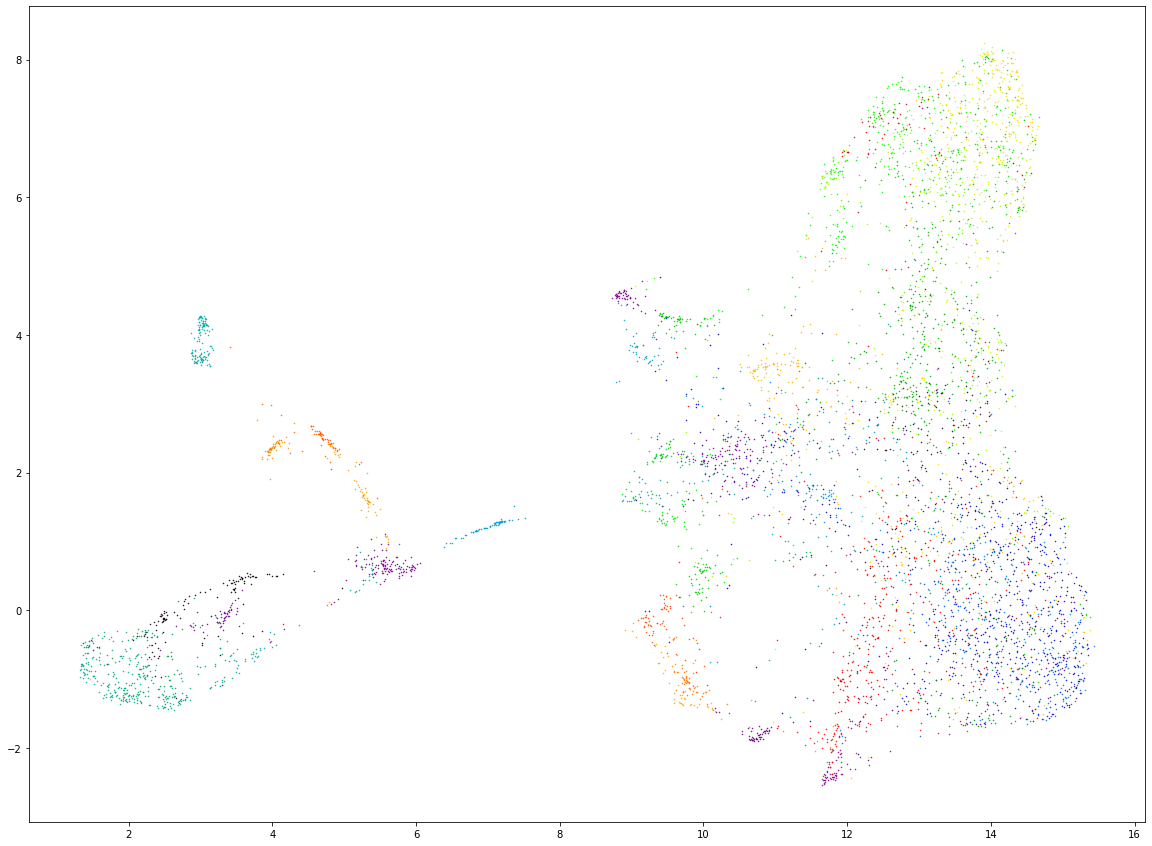

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 512
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 512
INFO:root:New best accuracy! 0.11854643646468307
INFO:root:TRAINING EPOCH 11
total_loss=0.27511: 100%|██████████| 173/173 [00:24<00:00,  7.09it/s]
INFO:root:TRAINING EPOCH 12
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.2066666666666666


total_loss=0.19568: 100%|██████████| 173/173 [00:25<00:00,  6.86it/s]
INFO:root:TRAINING EPOCH 13
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.17999999999999994


total_loss=0.08895: 100%|██████████| 173/173 [00:24<00:00,  6.98it/s]
INFO:root:TRAINING EPOCH 14
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.15333333333333327


total_loss=0.03524: 100%|██████████| 173/173 [00:25<00:00,  6.81it/s]
INFO:root:TRAINING EPOCH 15
  0%|          | 0/173 [00:00<?, ?it/s]

Margin is now 0.1266666666666666


total_loss=0.12564: 100%|██████████| 173/173 [00:25<00:00,  6.86it/s]
INFO:root:Evaluating epoch 15
INFO:root:Getting embeddings for the val split
  0%|          | 0/187 [00:00<?, ?it/s]

Margin is now 0.09999999999999992


100%|██████████| 187/187 [00:11<00:00, 16.52it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


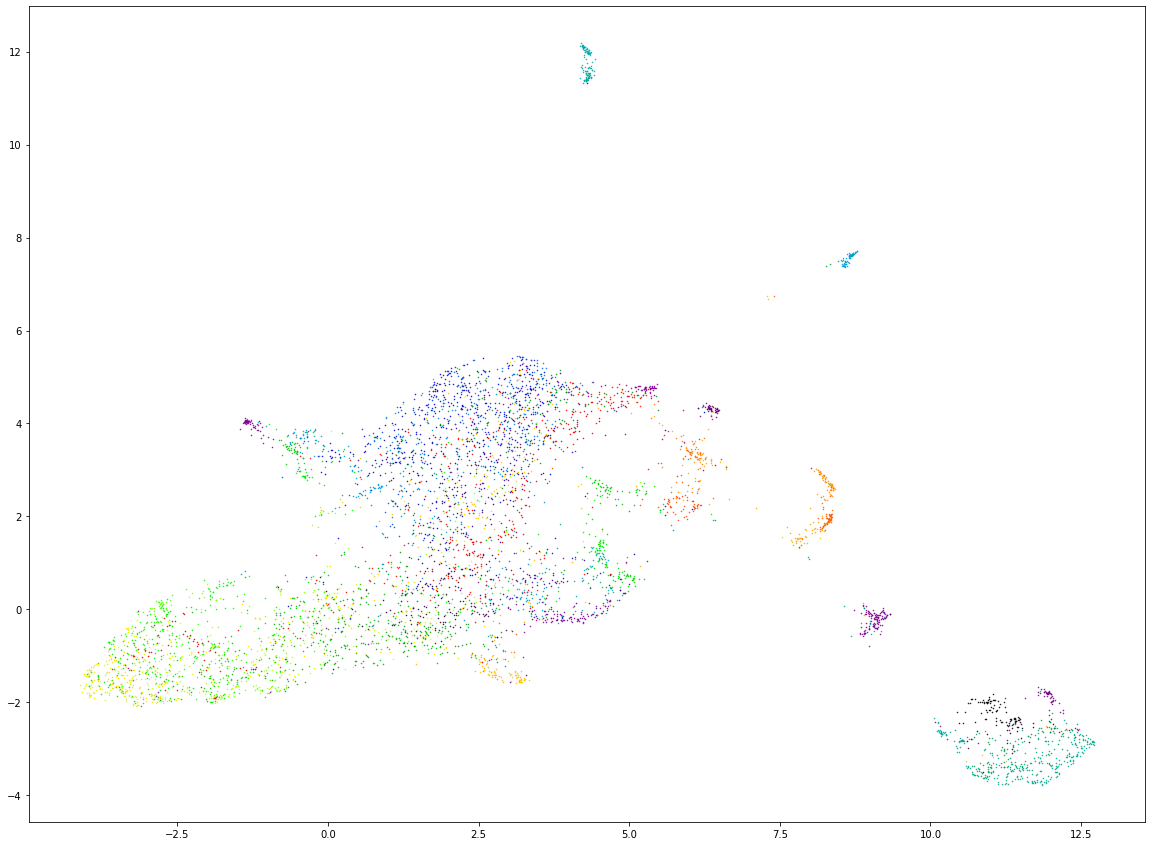

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 512
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 512
INFO:root:New best accuracy! 0.11891269509200234
INFO:root:TRAINING EPOCH 16
total_loss=0.11057: 100%|██████████| 173/173 [00:25<00:00,  6.74it/s]
INFO:root:TRAINING EPOCH 17
total_loss=0.09236: 100%|██████████| 173/173 [00:25<00:00,  6.83it/s]
INFO:root:TRAINING EPOCH 18
total_loss=0.07728: 100%|██████████| 173/173 [00:25<00:00,  6.83it/s]
INFO:root:TRAINING EPOCH 19
total_loss=0.07704: 100%|██████████| 173/173 [00:25<00:00,  6.71it/s]
INFO:root:TRAINING EPOCH 20
total_loss=0.03839: 100%|██████████| 173/173 [00:25<00:00,  6.76it/s]
INFO:root:Evaluating epoch 20
INFO:root:Getting embeddings for the val split
100%|██████████| 187/187 [00:11<00:00, 15.80it/s]
INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_lev

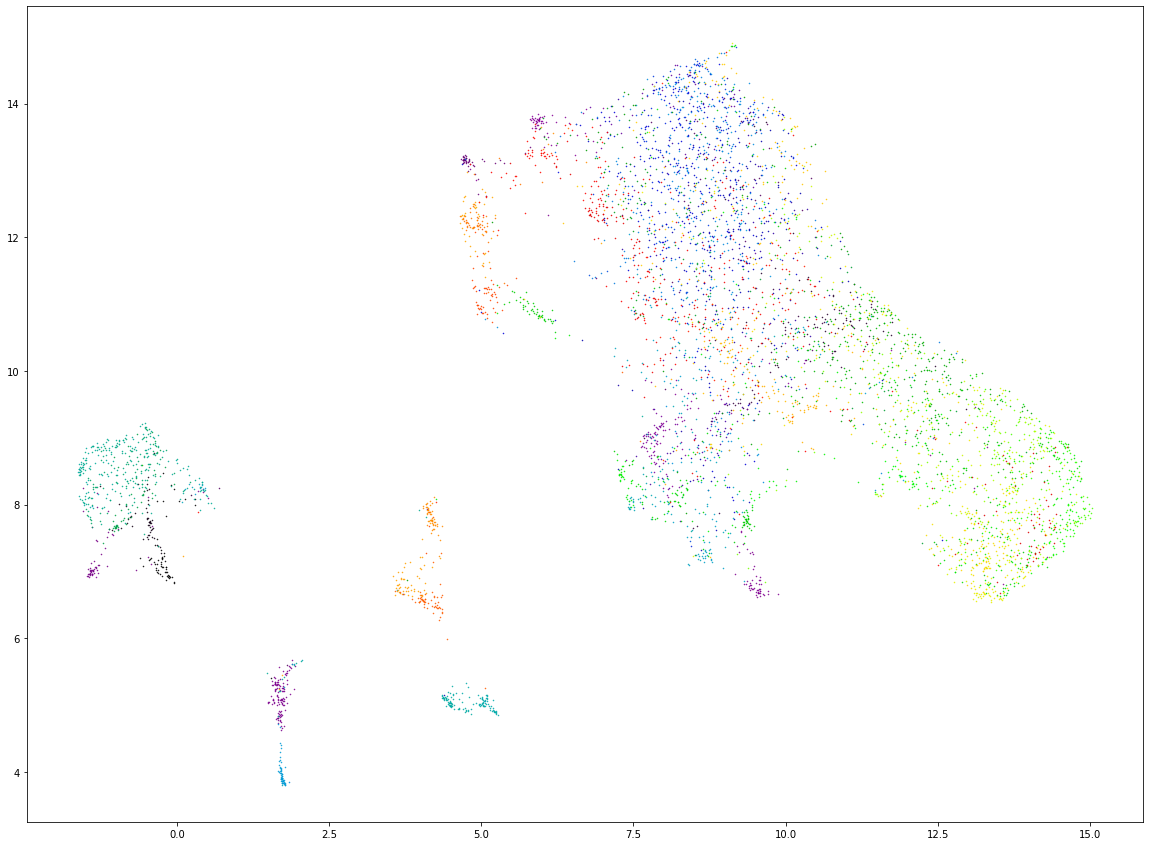

INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=60
INFO:root:embedding dimensionality is 512
INFO:root:running k-means clustering with k=101
INFO:root:embedding dimensionality is 512
INFO:root:Validation accuracy has plateaued. Exiting.


In [20]:
trainer.train(num_epochs=num_epochs)

# Evaluate results

In [21]:
match_finder = MatchFinder(mode="sim", threshold=0.7)
inference_model = InferenceModel(models['trunk'], embedder=models['embedder'], match_finder=match_finder)

## Visual evaluation

In [22]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

def print_decision(is_match):
    if is_match:
        print("Same class")
    else:
        print("Different class")

def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize = figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataset = val_dataset


In [23]:
class_a = dataset.targets[0]
class_b = dataset.targets[100]

class_a_idx = (dataset.targets == class_a).nonzero()[0]
class_b_idx = (dataset.targets == class_b).nonzero()[0]

In [24]:
class_a_idx[:10], class_b_idx[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([90, 91, 92, 93, 94, 95, 96, 97, 98, 99]))

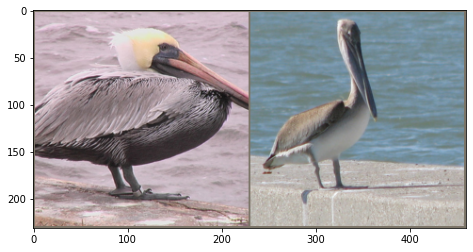

Same class


In [25]:
# compare two images of the same class
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_a_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

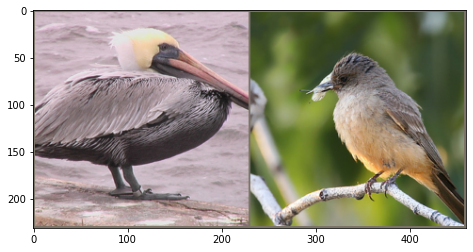

Different class


In [26]:
# compare two images of different classes
(x, _), (y, _) = dataset[class_a_idx[0]], dataset[class_b_idx[1]]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)

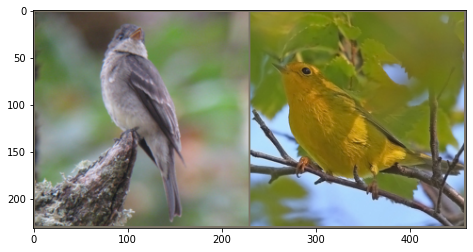

Different class
Actually different


In [27]:
# compare two random images
idx1 = np.random.choice(range(len(dataset)))
idx2 = np.random.choice(range(len(dataset)))
(x, x_label), (y, y_label) = dataset[idx1], dataset[idx2]
imshow(torchvision.utils.make_grid(torch.stack([x,y], dim=0)))
decision = inference_model.is_match(x.unsqueeze(0), y.unsqueeze(0))
print_decision(decision)
print('Actually same' if x_label==y_label else "Actually different")

## Evaluation datasets

In [28]:
gallery_dataset = Cub2011(root="CUB2011", train=True, transform=val_transform, download=False)
query_dataset = Cub2011(root="CUB2011", train=False, transform=val_transform, download=False)

In [29]:
# gallery_dataset = ClassDisjointDataSet(original_train, original_val, True, n_classes=n_classes, transform=val_transform)
# query_dataset = ClassDisjointDataSet(original_train, original_val, False, n_classes=n_classes, transform=val_transform)

inference_model.train_indexer([gallery_dataset[i][0] for i in range(len(gallery_dataset))], 512)

In [30]:
len(gallery_dataset), len(query_dataset)

(5994, 5794)

In [31]:
def get_many_embeddings(tensors, inference_model, batch_size=128, emb_dim=512):
    embeddings = torch.Tensor(len(tensors), emb_dim)
    for i in range(0, len(tensors), batch_size):
        embeddings[i:i + batch_size] = inference_model.get_embeddings(tensors[i:i + batch_size], None)[0]
    return embeddings

gallery_embeddings = get_many_embeddings([gallery_dataset[i][0] for i in range(len(gallery_dataset))], inference_model)
query_embeddings = get_many_embeddings([query_dataset[i][0] for i in range(len(query_dataset))], inference_model)

query_embeddings.numpy()## Scores

In [32]:
query_embeddings.numpy()[:10].shape

(10, 512)

In [33]:
gallery_labels = np.array([gallery_dataset[i][1] for i in range(len(gallery_dataset))])
query_labels = np.array([query_dataset[i][1] for i in range(len(query_dataset))])


calculator = AccuracyCalculator()
acc_dict = calculator.get_accuracy(query_embeddings.numpy(),
                                   gallery_embeddings.numpy(),
                                   query_labels,
                                   gallery_labels,
    embeddings_come_from_same_source=False
)

acc_dict

INFO:root:running k-nn with k=30
INFO:root:embedding dimensionality is 512
INFO:root:running k-means clustering with k=200
INFO:root:embedding dimensionality is 512


{'AMI': 0.5660372767573371,
 'NMI': 0.7263112796218086,
 'mean_average_precision_at_r': 0.26545737515062195,
 'precision_at_1': 0.5115636865723162,
 'r_precision': 0.3635814298580775}

## Retrieval

[[1.3360333e-12 1.2250969e-01 1.2587777e-01 1.3442738e-01 1.3693169e-01]]


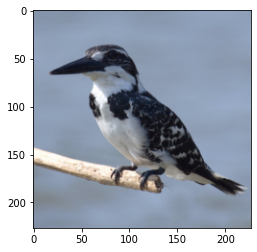

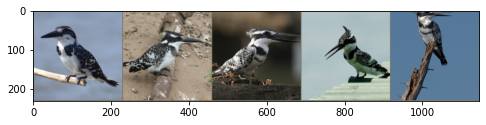

Query label 80
Neighbor labels [80 80 80 80 80]


In [34]:
k = 5
query_idx = np.random.randint(0, len(gallery_dataset))
query_img = gallery_dataset[query_idx][0]
query_batch =  [query_img]
# D, I = index.search(query_batch, k)
# print(D)

I, D = inference_model.get_nearest_neighbors(query_batch, k=k)
print(D)
neighbors_idx = I[0]
neighbors_imgs = [gallery_dataset[i][0] for i in neighbors_idx]
neighbors_labels = gallery_labels[neighbors_idx]

imshow(query_img)

imshow(torchvision.utils.make_grid(torch.stack(neighbors_imgs, dim=0)))
print('Query label', gallery_labels[query_idx])
print('Neighbor labels', neighbors_labels)

In [35]:
import itertools
from scipy.spatial.distance import pdist, cdist
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [36]:
same_label_distances = {}
diff_label_distances = {}

def get_label_vectors(label):
    label_indices = np.array(range(len(gallery_labels)))[gallery_labels == label]
    vectors = [gallery_embeddings[i].numpy() for i in label_indices]    
    return vectors

for label in tqdm(set(gallery_labels)):
    vectors = get_label_vectors(label)

    distances = pdist(vectors, metric='cosine')
    same_label_distances[label] = distances
    
    diff_labels = list(set(gallery_labels).difference(set([label])))
    other_label = np.random.choice(diff_labels)
    other_vectors = get_label_vectors(other_label)
    
    other_distances_matrix = cdist(vectors, other_vectors)
    other_distances = []
    # Get upper triangle of matrix
    for i in range(len(other_distances_matrix)-1):
        other_distances.append(other_distances_matrix[i][i+1:])
    other_distances = np.concatenate(other_distances)
    
    diff_label_distances[(label, other_label)] = other_distances

In [37]:
random_indices = np.random.choice(range(len(gallery_labels)), 1000)
random_distances = pdist(gallery_embeddings[random_indices].numpy(), metric='cosine')

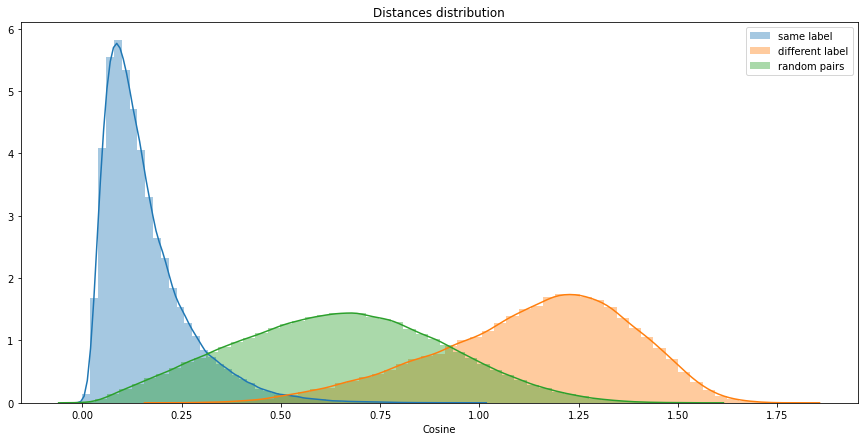

In [38]:
all_same_label_dists = np.concatenate([dists for l, dists in same_label_distances.items()])
all_diff_label_distances = np.concatenate([dists for l, dists in diff_label_distances.items()])

plt.figure(figsize=(15, 7))
sns.distplot(all_same_label_dists, label='same label')
sns.distplot(all_diff_label_distances, label='different label')
sns.distplot(random_distances, label='random pairs')
plt.xlabel('Cosine')
plt.title("Distances distribution")
plt.legend()
plt.show()

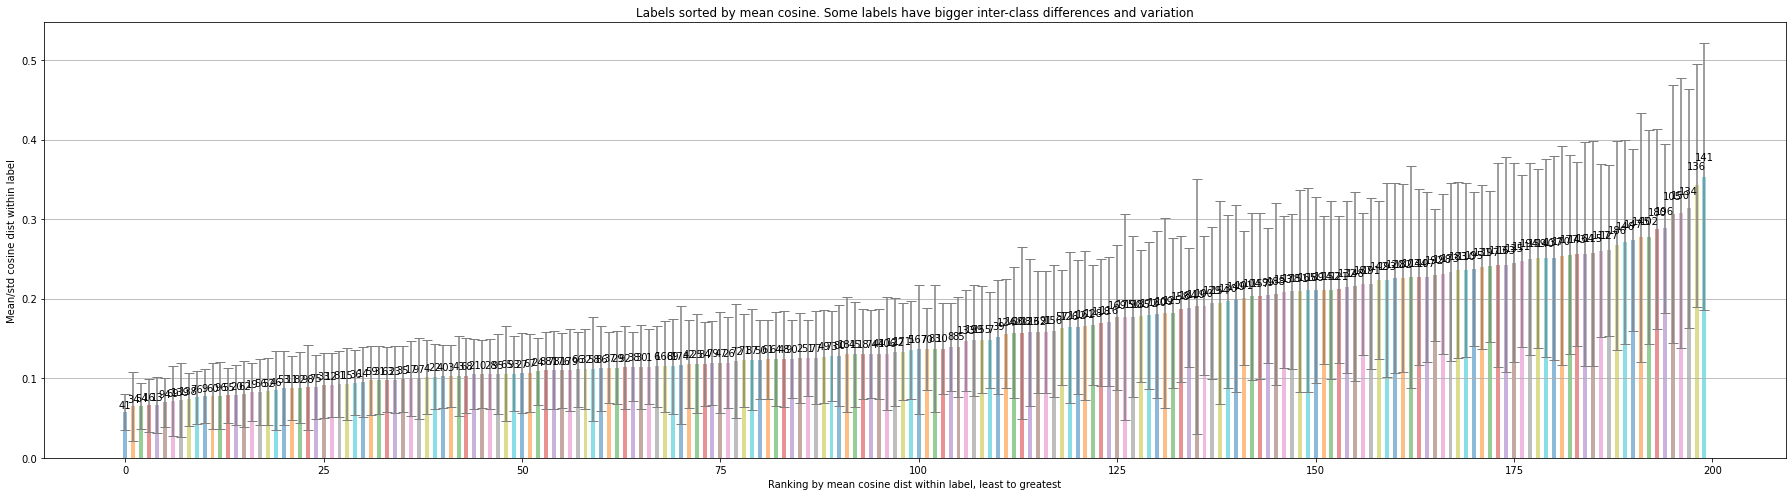

In [39]:
means = []
stds = []
for label, distances in same_label_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))
    
sort_order = np.argsort(means)

labels = [label for label in same_label_distances]
sorted_labels = np.array(labels)[sort_order]

def autolabel(rects, text):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                text,
                ha='center', va='bottom')
        
fig, ax = plt.subplots(figsize=(25, 7))
width = 0.5
for i, label in enumerate(sorted_labels):
    distances = same_label_distances[label]
    rects = ax.bar(i, np.mean(distances), width, yerr=np.std(distances), align='center', alpha=0.5, ecolor='grey', capsize=5)
    autolabel(rects, f'{label}')
    
    ax.yaxis.grid(True)


plt.ylabel("Mean/std cosine dist within label")
plt.xlabel('Ranking by mean cosine dist within label, least to greatest')
# Save the figure and show
plt.title("Labels sorted by mean cosine. Some labels have bigger inter-class differences and variation")
plt.tight_layout()
plt.show()